In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 11:01:32 2022

@author: Simone
"""

import numpy as np 
import pandas as pd 
#from random import randrange
#import random
#import sklearn
#%matplotlib inline
# import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib notebook
df = pd.read_csv("new/popSessoEtaLngLatSize2021.csv", dtype = {"ITTER107":str})
df

,ITTER107,Territorio,Sesso,Età,Value,lng,lat,Size km2
0,1272,Torino,maschi,0 anni,2900,7.680687,45.073274,130.17
1,1272,Torino,femmine,0 anni,2724,7.680687,45.073274,130.17
2,1272,Torino,totale,0 anni,5624,7.680687,45.073274,130.17
3,1272,Torino,femmine,1 anni,2890,7.680687,45.073274,130.17
4,1272,Torino,maschi,1 anni,3015,7.680687,45.073274,130.17
...,...,...,...,...,...,...,...,...
2460235,IT111,Sud Sardegna,maschi,25 anni,1585,NaN,NaN,NaN
2460236,IT111,Sud Sardegna,femmine,91 anni,720,NaN,NaN,NaN
2460237,IT111,Sud Sardegna,femmine,23 anni,1330,NaN,NaN,NaN
2460238,IT111,Sud Sardegna,maschi,totale,169114,NaN,NaN,NaN


## Preprocessing

In [2]:
df = df.loc[df['ITTER107'].str.isdigit()] #No areas
df = df.loc[df['Età'] != "totale"]
df = df.loc[df['Sesso'] != "totale"]
df['Età'] = df['Età'].map(lambda x: x.rstrip(' anni'))
df['Età'] = df['Età'].map(lambda x: x.rstrip(' anni e più'))
df['Età'] = df['Età'].astype(int)
#df = df.loc[df['Value'] > 50000]
#df.loc[df['Value'] > 1000000]
#https://todayfounder.com/market-segmentation-by-age-the-complete-guide/


In [3]:
bins= [0,3,13,20,30,40,50,60,70,80,90,100,110]
labels = ['Infant','Kid','Teen','Young adult','30s','40s','50s','60s','70s','80s','90s','100s or older']
df['AgeGroup'] = pd.cut(df['Età'], bins=bins, labels=labels, right=False) ##Create age groups
 #Sum population for age group, city and gender
df = df.loc[df['AgeGroup'] == "Teen"]
df = df.loc[df['Sesso'] == "maschi"]


groups = df.groupby(['Territorio'], as_index=False).agg({'Value':'sum','lat': 'first','lng':'first', 'Size km2':'first'})#["Value"].apply(lambda x : x.astype(int).sum()).to_frame(name = 'Value').reset_index()
df = groups
df['populPerKm2'] = df['Value']/df['Size km2']
df = df.loc[df['populPerKm2'] > 10]
df

,Territorio,Value,lat,lng,Size km2,populPerKm2
0,Abano Terme,609,45.359387,11.788713,21.57,28.233658
6,Abbiategrasso,1173,45.398576,8.917486,47.10,24.904459
17,Acerra,2827,40.945864,14.371184,54.08,52.274408
18,Aci Bonaccorsi,137,37.597894,15.108607,1.70,80.588235
19,Aci Castello,571,37.555818,15.145233,8.65,66.011561
...,...,...,...,...,...,...
7875,Zibido San Giacomo,295,45.359665,9.105877,24.61,11.986997
7883,Zola Predosa,642,44.492238,11.218183,37.76,17.002119
7891,Zugliano,244,45.733612,11.521429,13.76,17.732558
7893,Zumaglia,32,45.594785,8.088702,2.62,12.213740


## Clustering

In [4]:
# X = StandardScaler().fit_transform(df[['Value','lng','lat']])
ss = StandardScaler()
X = ss.fit_transform(df[['lng','lat']]) #'populPerKm2' per avere cluster di popolazione simile (non voluta)
#clustering = DBSCAN(eps=0.1, min_samples=10).fit(X)
km = KMeans(n_clusters=15,init = 'k-means++', random_state=0, max_iter = 1000)
clustering = km.fit(X)
np.unique(clustering.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [5]:
# Extract the data we're interested in
lat = df['lat'].values
lon = df['lng'].values
population = df['Value'].values
populationsqm = df['populPerKm2'].values
#area = cities['area_total_km2'].values

## Italy map 2d

<IPython.core.display.Javascript object>


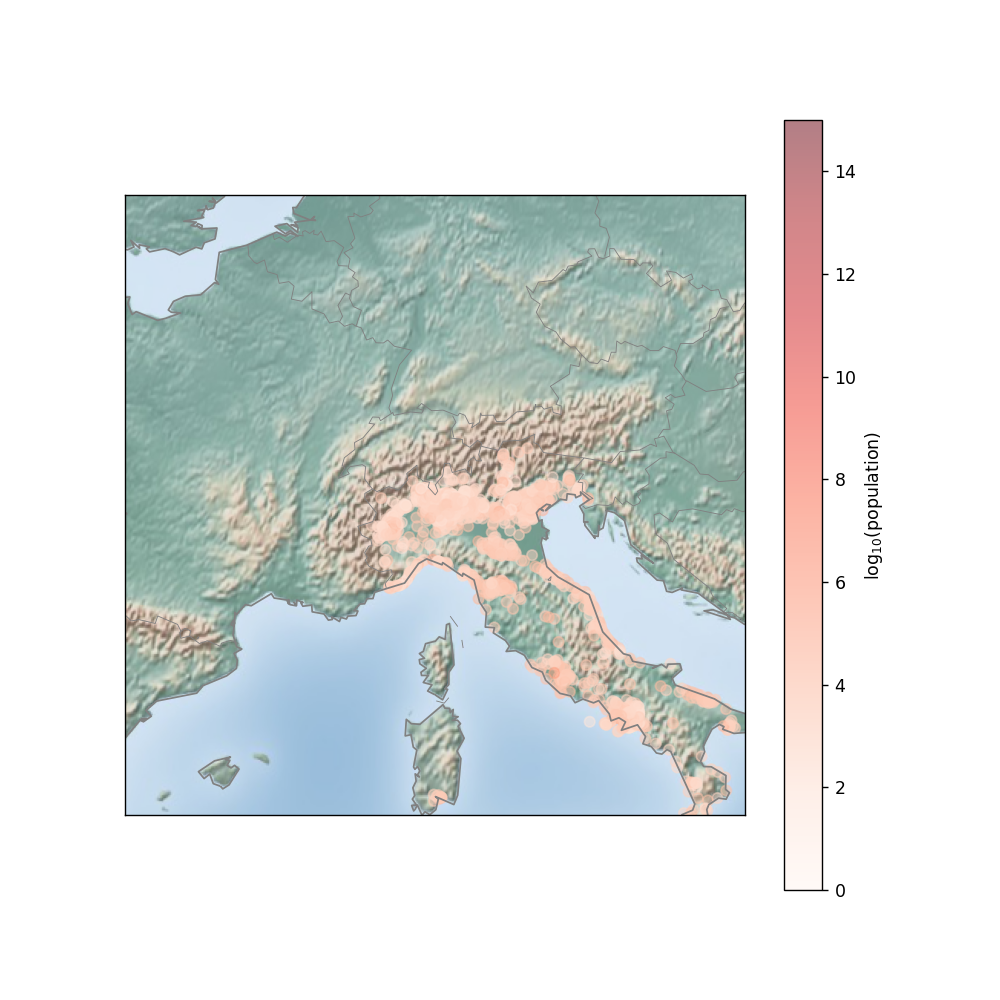

In [6]:
# 1. Draw the map background ITALY 2D
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=45.6, lon_0=9,
            width=1.5E6, height=1.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population),#s=area
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(0,15)

# # make legend with dummy points
# for a in [10, 100, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');

#For italy
#  lat_0=41.6, lon_0=13,
# width=1.2E6, height=1.5E6)

## ZOOM

<IPython.core.display.Javascript object>


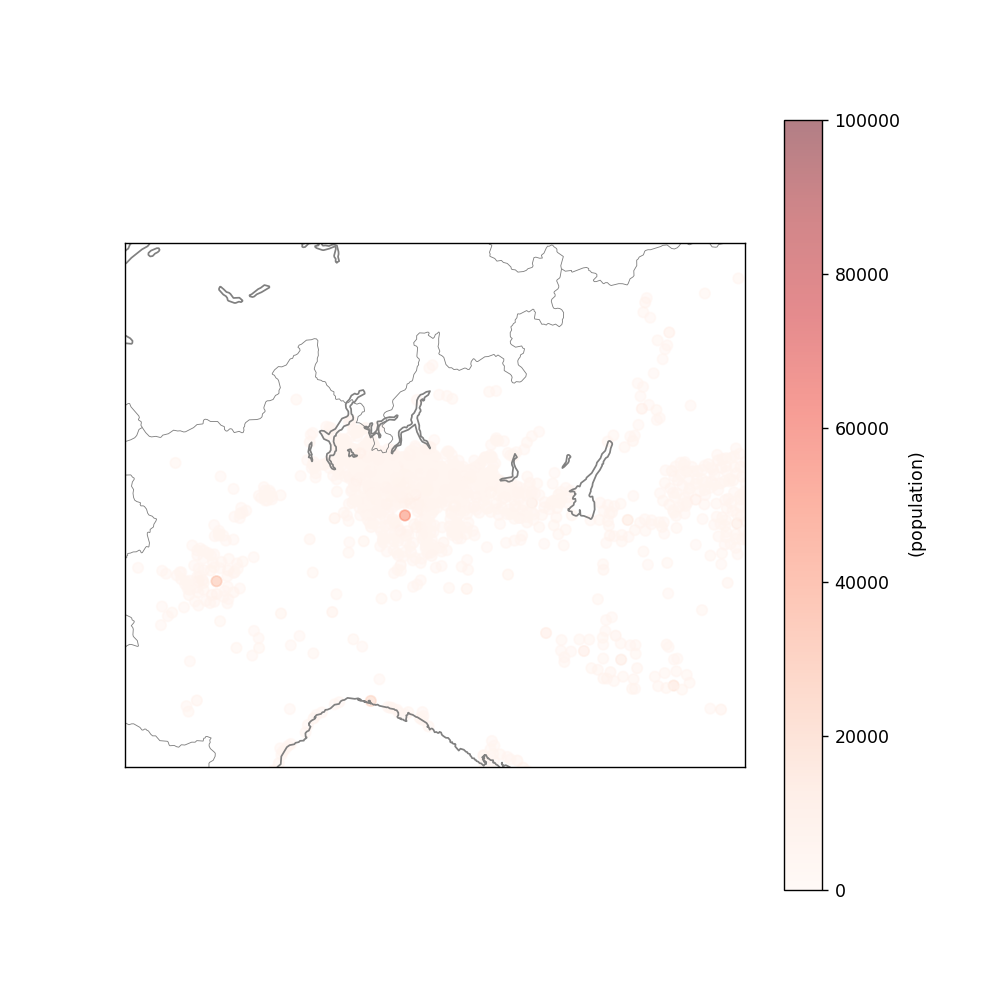

In [7]:
# 1. Draw the map background LOMBARDY 2D
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=45.5855, lon_0=9.9302,
            width=1.5E6, height=1.5E6,
            llcrnrlat=44, llcrnrlon=7, 
            urcrnrlat=47, urcrnrlon=12)
#m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=(population),
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$({\rm population})$')
plt.clim(0,100000)

# # make legend with dummy points
# for a in [10, 100, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');


In [8]:
# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# ax = plt.axes(projection='3d')

# # Data for a three-dimensional line
# zline = np.log10(population)
# xline = lon
# yline = lat
# ax.plot3D(xline, yline, zline, 'gray')

# # # Data for three-dimensional scattered points
# # zdata = 15 * np.random.random(100)
# # xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
# # ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
# # ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

## 3D map Italy

<IPython.core.display.Javascript object>


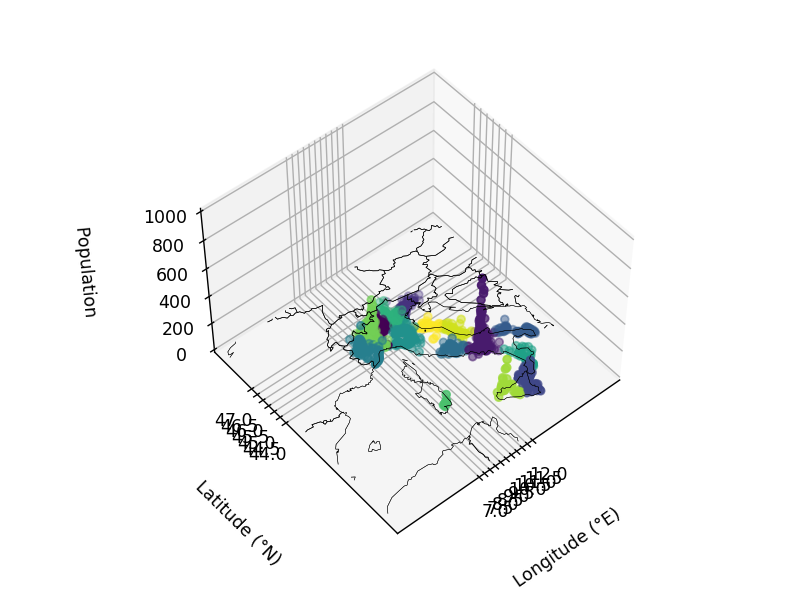

C:\Users\sarat\AppData\Local\Temp\ipykernel_9268\2258193314.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Create a basemap instance that draws the Earth layer
bm = Basemap(#llcrnrlat=44, llcrnrlon=7, 
            #urcrnrlat=47, urcrnrlon=12,
    llcrnrlat=35, llcrnrlon=0, 
            urcrnrlat=50, urcrnrlon=20,
             projection='cyl', resolution='l', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=230, elev=50)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population ', labelpad=20)
# Add meridian and parallel gridlines
lon_step = 0.5
lat_step = 0.5
meridians = np.arange(7, 12 + lon_step, lon_step)
parallels = np.arange(44, 47 + lat_step, lat_step)
ax.set_yticks(parallels)
ax.set_yticklabels(parallels)
ax.set_xticks(meridians)
ax.set_xticklabels(meridians)
ax.set_zlim(0., 1000)

cluster_colors = np.array(['green','blue','red'])
categories = clustering.labels_

colormap = np.arange(0,15)#(['black','y','r', 'g', 'b','pink','magenta','fucsia','cyan'])

p = ax.scatter(lon, lat, (populationsqm), c=colormap[categories])

plt.show()

In [10]:
import pyproj
import json
from shapely.geometry import Point, mapping
from functools import partial
from shapely.ops import transform

def km40Radius(c):
    point = Point(c)
    
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(40_000)

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)
    dic = mapping(buffer_wgs84)
    return np.asarray(dic['coordinates'])[0]

## 3D map Lombardy

<IPython.core.display.Javascript object>


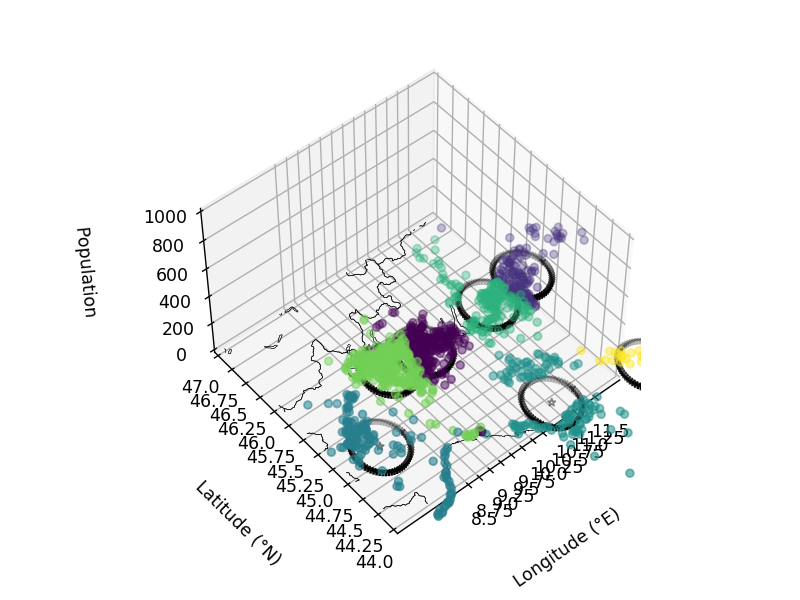

C:\Users\sarat\AppData\Local\Temp\ipykernel_9268\3494066550.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Create a basemap instance that draws the Earth layer
bm = Basemap(llcrnrlat=44, llcrnrlon=7, 
            urcrnrlat=47, urcrnrlon=12,
             projection='cyl', resolution='h', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=230, elev=50)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population ', labelpad=20)
# Add meridian and parallel gridlines
lon_step = 0.25
lat_step = 0.25
meridians = np.arange(8.5, 11.5 + lon_step, lon_step)
parallels = np.arange(44, 47 + lat_step, lat_step)
ax.set_yticks(parallels)
ax.set_yticklabels(parallels)
ax.set_xticks(meridians)
ax.set_xticklabels(meridians)
ax.set_zlim(0., 1000)

cluster_colors = np.array(['green','blue','red'])
categories = clustering.labels_

colormap = np.arange(0,15)
C = ss.inverse_transform(km.cluster_centers_)#Centroids
p = ax.scatter(lon, lat, (populationsqm), c=colormap[categories])#Points
p = ax.scatter(xs=C[:,0], ys=C[:,1], edgecolor='black', c='white', marker = '*')#Centers
for c in C:
    circle = km40Radius(c)
    p = ax.scatter(xs=circle[:,0], ys=circle[:,1], c='black', marker = '1')#Radius

plt.show()